In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import warnings

In [2]:
user_ratings=pd.read_csv("D:/自己的論文/ml-100k/u.data",sep="\t",names=["user_id","movie_id","rating"],usecols=[0,1,2])
movie_info=pd.read_csv("D:/自己的論文/ml-100k/u.item",sep="|",names=["movie_id","title"],usecols=[0,1],encoding="ISO-8859-1")

In [3]:
user_ratings=pd.merge(movie_info,user_ratings)
user_ratings.head()

,movie_id,title,user_id,rating
0,1,Toy Story (1995),308,4
1,1,Toy Story (1995),287,5
2,1,Toy Story (1995),148,4
3,1,Toy Story (1995),280,4
4,1,Toy Story (1995),66,3


In [4]:
user_ratings=user_ratings.pivot_table(index=["user_id"],
                                      columns=["title"],
                                      values="rating")
user_ratings.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN


In [5]:
user_ratings.shape

(943, 1664)

In [6]:
def df_fill_percentage(data):
    return round(data.notna().sum().sum() / (data.shape[0] * data.shape[1]) * 100,2)

In [7]:
df_fill_percentage(user_ratings)

6.35

<Axes: >

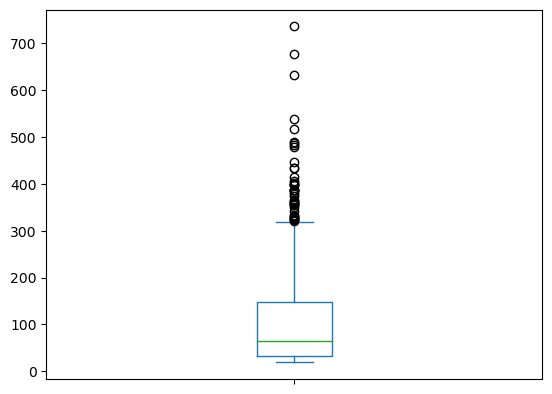

In [8]:
user_ratings.count(axis=1).plot(kind="box")

<Axes: ylabel='Frequency'>

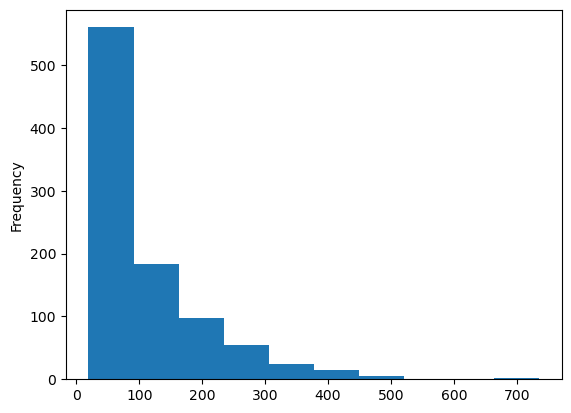

In [9]:
user_ratings.count(axis=1).plot(kind="hist")

In [10]:
user_distances=user_ratings.transpose().corr(method="pearson")

In [11]:
nneighbors=10
#保留至少有11個數字非NA值的列+行
user_distances=user_distances.dropna(axis=0,thresh=nneighbors+1).dropna(axis=1,thresh=nneighbors+1)

#讓矩陣為正方形
user_distances=user_distances.loc[user_distances.columns]

In [12]:
user_distances=1.0 - user_distances
user_distances[user_distances < 0] = 0

In [13]:
model_knn=NearestNeighbors(metric="precomputed",algorithm="brute",n_neighbors=10,n_jobs=-1)

model_knn.fit(csr_matrix(user_distances.fillna(0).values))
similarity,indexes=model_knn.kneighbors(csr_matrix(user_distances.fillna(0).values),
                                        n_neighbors=nneighbors)

c:\Users\gopl0\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:234: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


In [14]:
nneighbors=pd.DataFrame({"neighborhood_ids":[user_distances.iloc[neighbors].index.to_list() for neighbors in indexes],
                         "distance":similarity.tolist()},
                         index=user_distances.index)
nneighbors

,neighborhood_ids,distance
user_id,,
1,"[520, 107, 687, 34, 105, 740, 485, 400, 873, 510]","[0.08144134645630818, 0.08346578621692213, 0.0..."
2,"[426, 341, 476, 267, 310, 766, 352, 162, 338, ...","[1.1102230246251565e-16, 0.015268072165338209,..."
3,"[618, 879, 368, 563, 359, 906, 867, 512, 452, ...","[2.220446049250313e-16, 2.220446049250313e-16,..."
4,"[825, 899, 739, 169, 812, 168, 325, 80, 369, 711]","[2.220446049250313e-16, 0.015268072165338209, ..."
5,"[728, 791, 482, 565, 797, 415, 781, 931, 571, ...","[0.018019493938034148, 0.029274656605848937, 0..."
...,...,...
939,"[482, 578, 640, 728, 832, 609, 397, 451, 492, ...","[1.1102230246251565e-16, 1.1102230246251565e-1..."
940,"[726, 859, 300, 105, 289, 4, 510, 428, 353, 872]","[0.018019493938034148, 0.01801949393803437, 0...."
941,"[801, 243, 350, 781, 841, 451, 610, 93, 431, 574]","[1.1102230246251565e-16, 2.220446049250313e-16..."


In [15]:
neighbors=nneighbors["neighborhood_ids"].loc[1]
neighbors

[520, 107, 687, 34, 105, 740, 485, 400, 873, 510]

In [16]:
user_ratings.loc[neighbors].mean()

title
'Til There Was You (1997)                NaN
1-900 (1994)                             NaN
101 Dalmatians (1996)                    NaN
12 Angry Men (1957)                      NaN
187 (1997)                               2.5
                                        ... 
Young Guns II (1990)                     NaN
Young Poisoner's Handbook, The (1995)    NaN
Zeus and Roxanne (1997)                  NaN
unknown                                  NaN
Á köldum klaka (Cold Fever) (1994)       NaN
Length: 1664, dtype: float64

In [17]:
def usercf_predict_rating_closure(user_ratings,neighborhoods):
    def usercf_predict_rating_using_nmean(row):
        neighbors_ids=neighborhoods["neighborhood_ids"].loc[row.name]

        pred_ratings=user_ratings.loc[neighbors_ids].mean()
        return round(pred_ratings)
    return usercf_predict_rating_using_nmean

In [18]:
def recommendation_system_user_model(minperiods,nneighbors,user_ratings):
    user_distances=user_ratings.transpose().corr(method="pearson",min_periods=minperiods)
    user_distances=user_distances.dropna(axis=0,thresh=nneighbors+1).dropna(axis=1,thresh=nneighbors+1)

    user_distances=user_distances.loc[user_distances.columns]
    user_distances=1-user_distances
    user_distances[user_distances < 0] = 0

    model_knn=NearestNeighbors(metric="precomputed",algorithm="brute",
                               n_neighbors=nneighbors,n_jobs=-1)
    
    model_knn.fit(csr_matrix(user_distances.fillna(0).values))

    similarity,indexes=model_knn.kneighbors(csr_matrix(user_distances.fillna(0).values),
                                            n_neighbors=nneighbors)
    
    neighborhoods=pd.DataFrame({"neighborhood_ids":[user_distances.iloc[neighbors].index.tolist() for neighbors in indexes],
                                "distance":similarity.tolist()},
                                index=user_distances.index)
    
    #使用平均值結合ratings
    pred=user_ratings.reindex(neighborhoods.index).apply(usercf_predict_rating_closure(user_ratings,neighborhoods),axis="columns")

    user_ratings.merge(pred,how="right")
    return pred,neighborhoods

In [19]:
def mae(user_ratings,predicted_ratings):
    abs_dif=abs(user_ratings - predicted_ratings)

    n=np.sum(user_ratings.count())
    return abs_dif.sum().sum() / n

In [20]:
user_ratings_train=pd.read_csv("D:/自己的論文/ml-100k/u1.base",
                               sep="\t",names=["user_id","movie_id","rating"],usecols=[0,1,2])

user_ratings_test=pd.read_csv("D:/自己的論文/ml-100k/u1.test",
                              sep="\t",names=["user_id","movie_id","rating"],usecols=[0,1,2])

movie_info=pd.read_csv("D:/自己的論文/ml-100k/u.item",
                       sep="|",names=["movie_id","title"],usecols=[0,1],encoding="ISO-8859-1")

user_ratings_train=pd.merge(movie_info,user_ratings_train)
user_ratings_test=pd.merge(movie_info,user_ratings_test)

user_ratings_train=user_ratings_train.pivot_table(index=["user_id"],
                                                  columns=["title"],
                                                  values="rating")

user_ratings_test=user_ratings_test.pivot_table(index=["user_id"],
                                                columns=["title"],
                                                values="rating")

print(user_ratings_train.shape)
print(user_ratings_test.shape)

(943, 1633)
(459, 1401)


In [21]:
user_ratings_train=user_ratings_train.reindex(index=user_ratings_train.index.union(user_ratings_test.index),
                                              columns=user_ratings_train.columns.union(user_ratings_test.columns))
user_ratings_test=user_ratings_test.reindex(index=user_ratings_train.index.union(user_ratings_test.index),
                                            columns=user_ratings_train.columns.union(user_ratings_test.columns))

print(user_ratings_train.shape)
print(user_ratings_test.shape)

(943, 1664)
(943, 1664)


In [22]:
scoreboard=[]
for min_periods in [5,10,50,100]:
    for n_neighbors in [2,5,10,20,30]:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            pred,neighborhoods=recommendation_system_user_model(min_periods,
                                                                n_neighbors,
                                                                user_ratings_train)
            
            pred=pred.reindex(index=user_ratings_train.index)
            #MAE
            error=mae(user_ratings_test,pred)
            #不推薦給任何人的電影百分比
            m_not_rec=(pred.notna().sum(axis=0) == 0).sum() / pred.columns.size * 100
            #沒有推薦用戶的百分比
            u_not_rec=(pred.notna().sum(axis=1) == 0).sum() / pred.index.size * 100
            d={"Min Periods":min_periods,
               "KNN":n_neighbors,"MAE":error,
               "% of movies ignored":m_not_rec,"% of users ignored":u_not_rec,
               "fill %":df_fill_percentage(pred)}
            scoreboard.append(d)
scores=pd.DataFrame(scoreboard)
scores

,Min Periods,KNN,MAE,% of movies ignored,% of users ignored,fill %
0,5,2,0.157929,3.846154,0.106045,7.61
1,5,5,0.284938,1.983173,0.106045,15.30
2,5,10,0.398703,1.862981,0.212089,24.08
3,5,20,0.512493,1.862981,0.318134,35.69
4,5,30,0.592384,1.862981,0.636267,43.55
5,10,2,0.254970,2.403846,2.439024,11.67
6,10,5,0.400956,2.043269,3.711559,22.06
7,10,10,0.523559,1.923077,5.620361,32.42
8,10,20,0.626408,1.923077,7.635207,43.80
9,10,30,0.662135,1.923077,9.862142,49.79


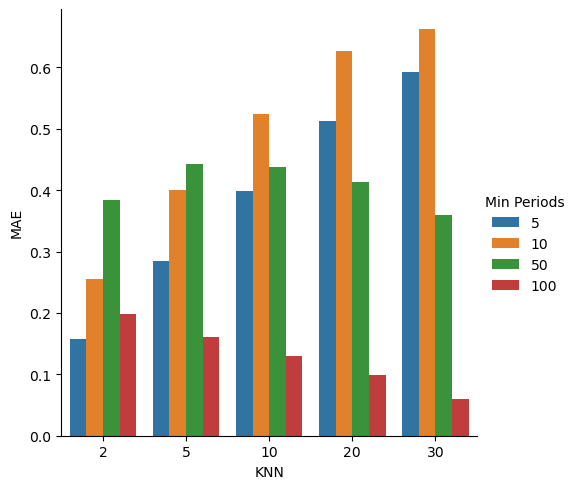

In [23]:
sns.catplot(data=scores,kind="bar",x="KNN",y="MAE",hue="Min Periods")

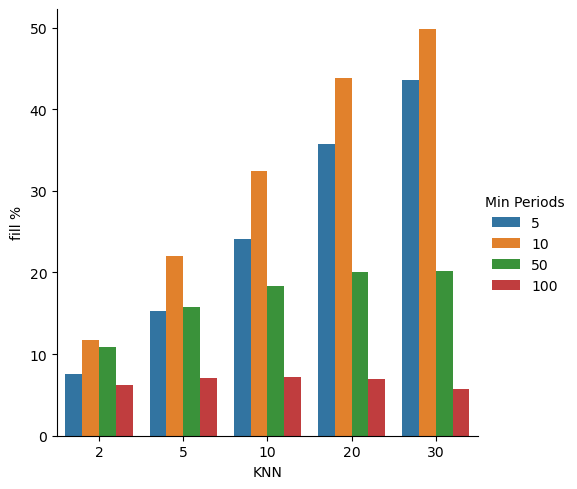

In [24]:
sns.catplot(data=scores,kind="bar",x="KNN",y="fill %",hue="Min Periods")

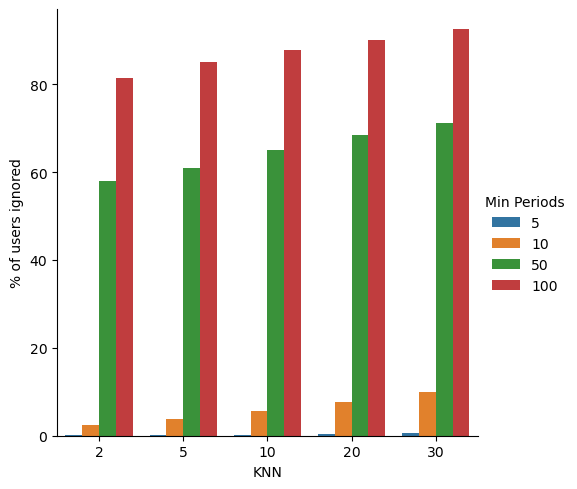

In [25]:
sns.catplot(data=scores,kind="bar",x="KNN",y="% of users ignored",hue="Min Periods")

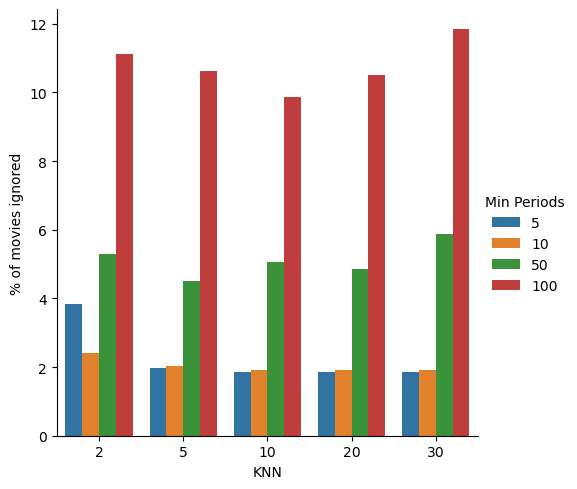

In [26]:
sns.catplot(data=scores,kind="bar",x="KNN",y="% of movies ignored",hue="Min Periods")

In [27]:
pred_user,neighborhoods_user=recommendation_system_user_model(5,10,user_ratings_train)
pred_user=pred_user.reindex(index=user_ratings_train.index)

error=mae(user_ratings_test,pred_user)
error

c:\Users\gopl0\anaconda3\lib\site-packages\sklearn\neighbors\_base.py:234: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


0.3987031195233088

In [28]:
pred_user

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
3,NaN,NaN,2.0,4.0,2.0,2.0,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,4.0,4.0,2.0,NaN,NaN,NaN,NaN
4,NaN,NaN,3.0,5.0,3.0,3.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,2.0,4.0,4.0,NaN,4.0,4.0,NaN,5.0,...,NaN,NaN,NaN,4.0,NaN,3.0,2.0,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,1.0,4.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN


In [29]:
df_fill_percentage(pred_user) - df_fill_percentage(user_ratings_train)

18.99

<Axes: >

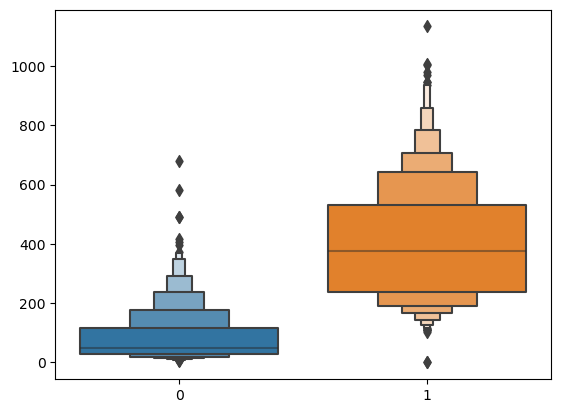

In [30]:
sns.boxenplot(data=[user_ratings_train.count(axis=1),pred_user.count(axis=1)])

In [31]:
id1_neighbors=neighborhoods_user.iloc[1]
id1_neighbors

neighborhood_ids    [23, 193, 933, 288, 585, 929, 915, 651, 556, 646]
distance            [0.03374849272632874, 0.04460636804251583, 0.0...
Name: 2, dtype: object

In [32]:
user_ratings.loc[[1]+id1_neighbors["neighborhood_ids"]].dropna(axis="columns",thresh=3)

title,12 Angry Men (1957),2001: A Space Odyssey (1968),Air Force One (1997),Aladdin (1992),Alien (1979),Aliens (1986),Amistad (1997),Antonia's Line (1995),Apocalypse Now (1979),Apollo 13 (1995),...,To Kill a Mockingbird (1962),Top Gun (1986),Toy Story (1995),Twelve Monkeys (1995),"Usual Suspects, The (1995)",Vertigo (1958),Wag the Dog (1997),When Harry Met Sally... (1989),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)"
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,NaN,4.0,5.0,5.0,NaN,5.0,3.0,4.0,...,NaN,4.0,5.0,4.0,5.0,NaN,NaN,5.0,4.0,4.0
23,NaN,NaN,NaN,4.0,3.0,3.0,NaN,4.0,NaN,3.0,...,5.0,2.0,5.0,4.0,NaN,5.0,NaN,4.0,3.0,4.0
193,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN
933,NaN,4.0,NaN,3.0,4.0,3.0,NaN,NaN,5.0,4.0,...,NaN,2.0,3.0,4.0,4.0,NaN,NaN,3.0,4.0,3.0
288,5.0,NaN,5.0,NaN,NaN,4.0,NaN,NaN,5.0,NaN,...,5.0,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,3.0
585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,3.0,NaN,4.0,4.0,NaN,NaN,NaN,NaN
915,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
user_ratings_test.loc[208].sort_values(ascending=False)[:20]

title
Graduate, The (1967)                         5.0
Being There (1979)                           5.0
When Harry Met Sally... (1989)               5.0
Butch Cassidy and the Sundance Kid (1969)    5.0
Sleepless in Seattle (1993)                  5.0
M*A*S*H (1970)                               5.0
Annie Hall (1977)                            4.0
Somewhere in Time (1980)                     4.0
Harold and Maude (1971)                      4.0
Groundhog Day (1993)                         4.0
Great Dictator, The (1940)                   4.0
Ghost (1990)                                 4.0
Duck Soup (1933)                             4.0
Cool Hand Luke (1967)                        4.0
Blues Brothers, The (1980)                   4.0
Young Frankenstein (1974)                    4.0
Back to the Future (1985)                    3.0
Four Weddings and a Funeral (1994)           3.0
Muriel's Wedding (1994)                      3.0
Pulp Fiction (1994)                          2.0
Name: 208, dty

In [34]:
pred_user[user_ratings_test.loc[208].sort_values(ascending=False)[:20].index].loc[208]

title
Graduate, The (1967)                         4.0
Being There (1979)                           4.0
When Harry Met Sally... (1989)               4.0
Butch Cassidy and the Sundance Kid (1969)    5.0
Sleepless in Seattle (1993)                  4.0
M*A*S*H (1970)                               4.0
Annie Hall (1977)                            3.0
Somewhere in Time (1980)                     5.0
Harold and Maude (1971)                      3.0
Groundhog Day (1993)                         4.0
Great Dictator, The (1940)                   NaN
Ghost (1990)                                 4.0
Duck Soup (1933)                             4.0
Cool Hand Luke (1967)                        4.0
Blues Brothers, The (1980)                   4.0
Young Frankenstein (1974)                    5.0
Back to the Future (1985)                    4.0
Four Weddings and a Funeral (1994)           3.0
Muriel's Wedding (1994)                      4.0
Pulp Fiction (1994)                          4.0
Name: 208, dty